In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
%matplotlib inline

# Helper: Chebyshev bound function

In [2]:
def chebyshev_bound(k):
    """Return the guaranteed proportion of data inside k standard deviations."""
    if k <= 1:
        return 0.0
    return 1 - 1/(k**2)

# Quick sanity check
for k in [2, 3, 4, 5]:
    print(f"k={k:>2} → at least {chebyshev_bound(k):.2%} inside ±{k}σ")

k= 2 → at least 75.00% inside ±2σ
k= 3 → at least 88.89% inside ±3σ
k= 4 → at least 93.75% inside ±4σ
k= 5 → at least 96.00% inside ±5σ


# Five Business Datasets (synthetic but realistic)

In [3]:
np.random.seed(42)

# 1. Manufacturing – bottle fill volume (ml)
fill_vol = np.random.normal(loc=500, scale=10, size=10_000)

# 2. E-commerce – delivery days
delivery_days = np.random.lognormal(mean=1.0, sigma=0.4, size=10_000)   # skewed!

# 3. Call-center – wait time (minutes)
wait_min = np.random.gamma(shape=2, scale=1, size=10_000) * 1.0   # right-skewed

# 4. Stock returns – daily % change
returns = np.random.normal(loc=0.1, scale=2.0, size=10_000)

# 5. Customer Lifetime Value (₹)
clv = np.random.weibull(a=1.5, size=10_000) * 30000 + 20000   # heavy tail

datasets = {
    "Bottle Fill (ml)": fill_vol,
    "Delivery Days": delivery_days,
    "Wait Time (min)": wait_min,
    "Daily Return (%)": returns,
    "CLV (₹)": clv
}

# Core analysis function

In [4]:
def analyze_chebyshev(data, name, k_values=[2, 3, 4]):
    mu = data.mean()
    sigma = data.std(ddof=0)   # population std (Chebyshev uses population σ)
    
    print(f"\n=== {name} ===")
    print(f"Mean μ = {mu:,.2f}")
    print(f"Std  σ = {sigma:,.2f}")
    
    results = []
    for k in k_values:
        lower = mu - k*sigma
        upper = mu + k*sigma
        inside = ((data >= lower) & (data <= upper)).mean()
        guarantee = chebyshev_bound(k)
        results.append({
            "k": k,
            "Lower": lower,
            "Upper": upper,
            "Observed %": inside,
            "Chebyshev ≥ %": guarantee
        })
        print(f"\nk={k}")
        print(f"  [{lower:,.2f}, {upper:,.2f}]")
        print(f"  Observed inside: {inside:.2%}")
        print(f"  Chebyshev guarantee: ≥{guarantee:.2%}")
    
    return pd.DataFrame(results)

# Run on all five business cases

In [29]:
import pathlib, datetime

def save(fig=None, name=None, dpi=200):
    fig = fig or plt.gcf()
    name = name or f"plot_{datetime.datetime.now():%Y%m%d_%H%M%S}.png"
    path = pathlib.Path.cwd() / name
    fig.savefig(path, dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"Saved → {path.resolve()}")
    return path

In [5]:
all_results = []
for name, data in datasets.items():
    df = analyze_chebyshev(data, name)
    df["Dataset"] = name
    all_results.append(df)

summary = pd.concat(all_results).reset_index(drop=True)
summary


=== Bottle Fill (ml) ===
Mean μ = 499.98
Std  σ = 10.03

k=2
  [479.91, 520.05]
  Observed inside: 95.38%
  Chebyshev guarantee: ≥75.00%

k=3
  [469.88, 530.08]
  Observed inside: 99.73%
  Chebyshev guarantee: ≥88.89%

k=4
  [459.84, 540.12]
  Observed inside: 100.00%
  Chebyshev guarantee: ≥93.75%

=== Delivery Days ===
Mean μ = 2.96
Std  σ = 1.24

k=2
  [0.49, 5.44]
  Observed inside: 95.73%
  Chebyshev guarantee: ≥75.00%

k=3
  [-0.75, 6.67]
  Observed inside: 98.76%
  Chebyshev guarantee: ≥88.89%

k=4
  [-1.99, 7.91]
  Observed inside: 99.57%
  Chebyshev guarantee: ≥93.75%

=== Wait Time (min) ===
Mean μ = 1.98
Std  σ = 1.41

k=2
  [-0.84, 4.81]
  Observed inside: 95.26%
  Chebyshev guarantee: ≥75.00%

k=3
  [-2.26, 6.22]
  Observed inside: 98.51%
  Chebyshev guarantee: ≥88.89%

k=4
  [-3.67, 7.63]
  Observed inside: 99.58%
  Chebyshev guarantee: ≥93.75%

=== Daily Return (%) ===
Mean μ = 0.11
Std  σ = 2.01

k=2
  [-3.90, 4.13]
  Observed inside: 95.64%
  Chebyshev guarantee: ≥75.

,k,Lower,Upper,Observed %,Chebyshev ≥ %,Dataset
0,2,479.910396,520.046884,0.9538,0.750000,Bottle Fill (ml)
1,3,469.876274,530.081006,0.9973,0.888889,Bottle Fill (ml)
2,4,459.842152,540.115128,1.0000,0.937500,Bottle Fill (ml)
3,2,0.486652,5.435541,0.9573,0.750000,Delivery Days
4,3,-0.750570,6.672764,0.9876,0.888889,Delivery Days
5,4,-1.987792,7.909986,0.9957,0.937500,Delivery Days
6,2,-0.844474,4.805269,0.9526,0.750000,Wait Time (min)
7,3,-2.256910,6.217704,0.9851,0.888889,Wait Time (min)
8,4,-3.669346,7.630140,0.9958,0.937500,Wait Time (min)
9,2,-3.898937,4.128087,0.9564,0.750000,Daily Return (%)


# Visual comparison: Observed vs. Chebyshev guarantee

Saved → E:\recent works\chebyshevs inequality\plot_20251107_113100.png


WindowsPath('E:/recent works/chebyshevs inequality/plot_20251107_113100.png')

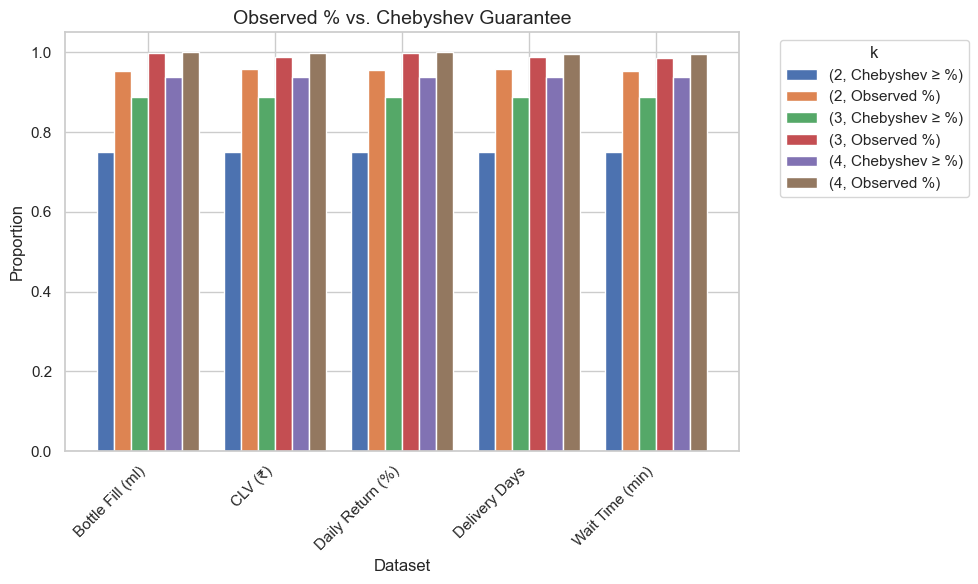

In [31]:
pivot = summary.pivot(index="Dataset", columns="k", values=["Observed %", "Chebyshev ≥ %"])
pivot = pivot.swaplevel(axis=1).sort_index(axis=1)

fig, ax = plt.subplots(figsize=(10,6))
pivot.plot(kind="bar", ax=ax, width=0.8)
ax.set_title("Observed % vs. Chebyshev Guarantee", fontsize=14)
ax.set_ylabel("Proportion")
ax.legend(title="k", bbox_to_anchor=(1.05,1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.show()
# plt.savefig("./chebyshev.png",facecolor='white')
save()

# Caution demo – when the bound is too loose

In [7]:
# Normal data (tight)
normal_data = np.random.normal(0,1,10000)

# Heavy-tailed Cauchy (no finite variance!)
cauchy_data = np.random.standard_cauchy(10000)

print("Normal σ =", normal_data.std())
print("Cauchy σ =", cauchy_data.std())   # huge number, changes every run

# Chebyshev fails on Cauchy because variance is infinite

Normal σ = 0.9999505532416575
Cauchy σ = 83.55891215649905


# Fixes 

In [19]:
# 1. Use Median Absolute Deviation (MAD) – robust to outliers
def mad(x):
    return np.median(np.abs(x - np.median(x)))

# 2. Percentile-based rule (non-parametric)
def percentile_rule(x, p=0.95):
    lower = np.percentile(x, (1-p)/2*100)
    upper = np.percentile(x, (1+p)/2*100)
    return lower, upper, np.mean(((x>=lower)*(x<=upper)))
# Example on CLV (skewed)
lower, upper, prop = percentile_rule(clv, p=0.95)
print(f"95% of CLV in [{lower:.0f}, {upper:.0f}], observed {prop:.2%}")

95% of CLV in [22711, 90364], observed 95.00%


# One-liner for any new dataset

In [20]:
def quick_chebyshev_check(data, k=3):
    mu, sigma = data.mean(), data.std(ddof=0)
    bound = chebyshev_bound(k)
    observed = ((data >= mu-k*sigma) & (data <= mu+k*sigma)).mean()
    return f"±{k}σ → Chebyshev ≥{bound:.1%}, observed {observed:.1%}"

# Try it on your own CSV column
# df = pd.read_csv("my_sales.csv")
# print(quick_chebyshev_check(df["revenue"], k=2))